In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

In [23]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

In [24]:
train_ds, valid_ds = ds["train"], ds["validation"]

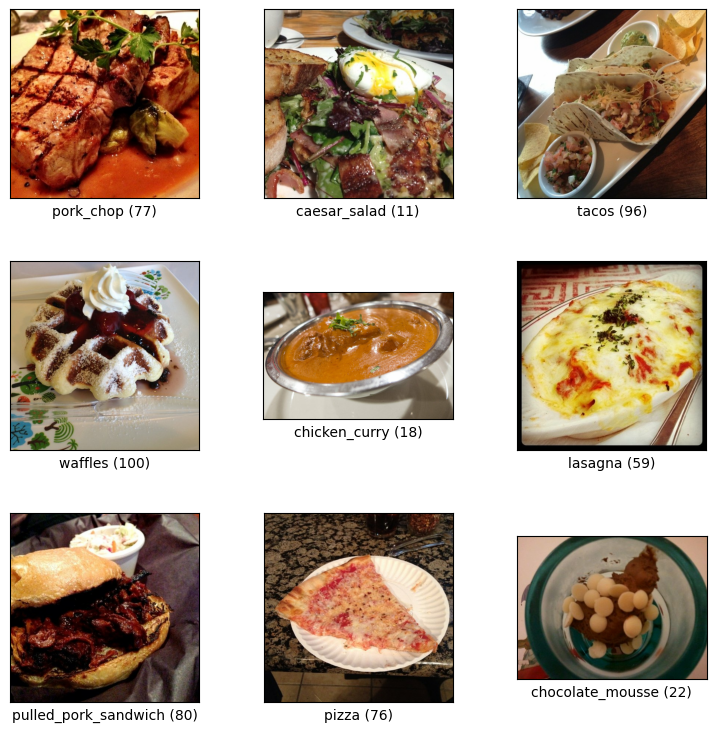

In [25]:
fig = tfds.show_examples(train_ds, ds_info)

In [27]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55

train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype = tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype = tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

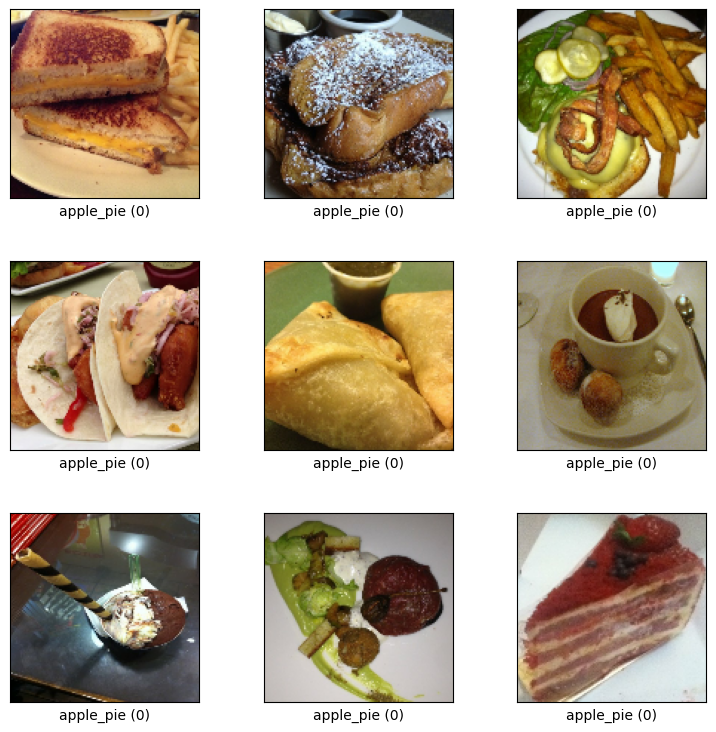

In [28]:
fig = tfds.show_examples(train_ds, ds_info)

In [30]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [31]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda image, label: label == 0)

In [32]:
batch_size = 16

train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                               [0.5, 0.5],
                                               stop_on_empty_dataset = True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                               [0.5, 0.5],
                                               stop_on_empty_dataset = True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [33]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [101 116 123]
   [124 137 145]
   [141 152 156]]

  [[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [ 80  95 102]
   [ 94 107 115]
   [107 118 122]]

  [[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [136 146 147]
   [138 149 153]
   [136 145 142]]

  ...

  [[134  25  28]
   [134  25  28]
   [134  25  28]
   ...
   [158  51  69]
   [159  52  68]
   [160  53  68]]

  [[129  25  24]
   [133  24  26]
   [135  25  27]
   ...
   [154  46  62]
   [157  49  65]
   [160  52  67]]

  [[130  26  22]
   [133  25  23]
   [134  24  23]
   ...
   [155  48  67]
   [157  50  70]
   [159  52  73]]]


 [[[ 70  47  41]
   [145 125 114]
   [174 156 139]
   ...
   [ 48  46  26]
   [194 194 173]
   [190 179 159]]

  [[174 157 141]
   [172 156 140]
   [173 158 139]
   ...
   [149 147 126]
   [194 192 174]
   [190 177 159]]

  [[171 156 133]
   [167 155 132]
   [171 159 140]
   ...
   [192 190 168]
   [192 189 174]


# CNN Implementation

In [34]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [35]:
for i,_ in ds["train"].take(1):
  image = i

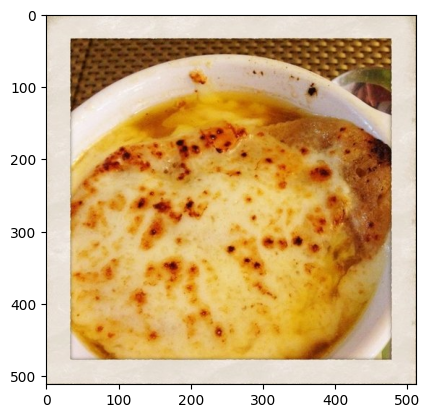

In [36]:
plt.imshow(image)

In [37]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

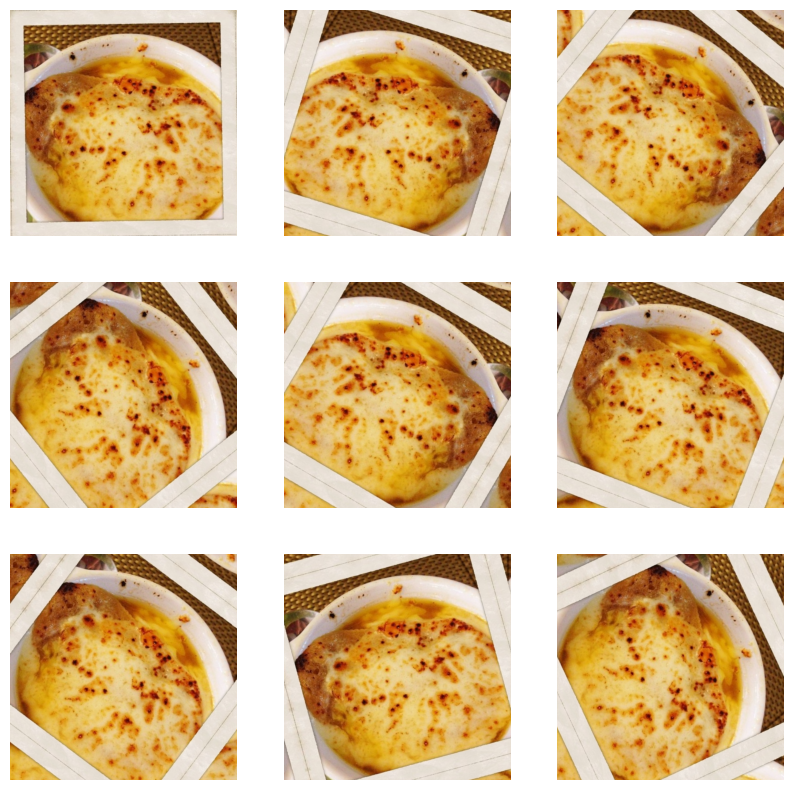

In [38]:
plt.figure(figsize = (10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [39]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3, 3), activation = 'relu', input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l = 0.01)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l = 0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [40]:
lr = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [41]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = epochs,
    verbose = 1
)

Epoch 1/50
277/277 [==============================] - 717s 3s/step - loss: 1.4432 - accuracy: 0.4891 - val_loss: 1.1867 - val_accuracy: 0.5050
Epoch 2/50
277/277 [==============================] - 235s 847ms/step - loss: 1.0395 - accuracy: 0.5025 - val_loss: 0.9269 - val_accuracy: 0.5294
Epoch 3/50
277/277 [==============================] - 245s 883ms/step - loss: 0.8669 - accuracy: 0.5219 - val_loss: 0.8207 - val_accuracy: 0.5716
Epoch 4/50
277/277 [==============================] - 240s 867ms/step - loss: 0.7895 - accuracy: 0.5380 - val_loss: 0.7620 - val_accuracy: 0.6238
Epoch 5/50
277/277 [==============================] - 238s 861ms/step - loss: 0.7493 - accuracy: 0.5561 - val_loss: 0.7284 - val_accuracy: 0.6356
Epoch 6/50
277/277 [==============================] - 234s 844ms/step - loss: 0.7241 - accuracy: 0.5703 - val_loss: 0.7082 - val_accuracy: 0.6376
Epoch 7/50
277/277 [==============================] - 238s 861ms/step - loss: 0.7050 - accuracy: 0.5733 - val_loss: 0.6812 - va

In [42]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

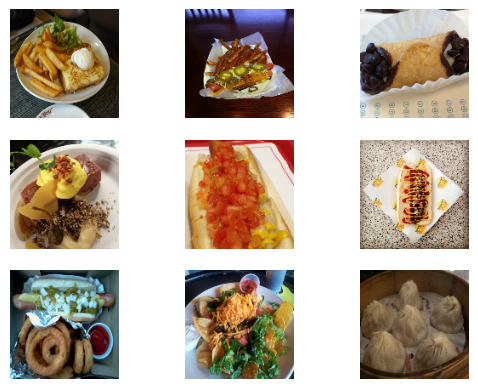

In [43]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [44]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int32)>